In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import learning_curve

from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [64]:
def ROC(X_test,y_test,model):
    y_pred_proba = model.predict_proba(X_test)
    lr_probs = y_pred_proba[:,1]
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = metrics.roc_auc_score(y_test, ns_probs)
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
    lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='DT')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Treeb: ROC AUC=%.3f' % (lr_auc))

In [65]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Metricas de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VN = churm[0,0]
    FP = churm[0,1]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Metricas de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VN = churm[1,1]
    FP = churm[1,0]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [66]:
def matriz_confusion(validacion, prediccion, cmap):
    print(colored('Matriz de confusión', attrs=['bold']))
    churm = metrics.confusion_matrix(validacion, prediccion)
    plt.imshow(churm, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not_mine','Mine'])
    plt.yticks(tick_marks, ['Not_mine','Mine'])
    return churm

# Importar datos Puros Tratados

In [67]:
data = pd.read_csv('./dataA.csv')
data.head(4)

,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,Avg_pps,...,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine
0,-0.084787,-0.685410,-0.244709,-0.196223,0.361252,-0.132463,-0.625504,-0.317443,-0.359303,-0.336093,...,-0.343648,-0.398552,-0.417145,-0.476095,-0.558694,0,0,1,0,0
1,0.097929,-0.396662,-0.458780,-0.451115,0.409764,-0.352407,-0.625504,-0.309740,-0.359148,-0.308138,...,-0.372665,-0.423315,-0.417145,-0.482557,-0.565459,0,0,1,0,0
2,-0.022141,-0.632190,-0.074370,-0.007831,0.791878,0.572379,-0.625504,0.899656,0.216184,0.446664,...,-0.358157,-0.313647,-0.410669,-0.473671,-0.423312,0,0,1,0,0
3,-0.502423,2.149904,2.128327,2.109300,-0.351008,2.077954,2.160192,-0.369684,-0.364646,-0.392005,...,-0.169549,-0.239356,-0.221081,-0.274899,-0.355679,0,0,1,0,1


# Modelo

### Holdout

In [68]:
best_feature_pure = ['Avg_bps','Avg_bpp' ,'Avg_pps','p3_ip','p3_ib']
y = data['Type_mine']
X = data[best_feature_pure]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size=0.3, random_state = 1234)

In [70]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [71]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 5
Número de nodos terminales: 15


[Text(327.825, 498.3, 'Avg_pps <= -0.35\nsamples = 3313\nvalue = [1746, 1567]\nclass = T'),
 Text(209.25, 407.70000000000005, 'p3_ib <= -0.523\nsamples = 1950\nvalue = [395, 1555]\nclass = i'),
 Text(111.6, 317.1, 'Avg_bpp <= -1.175\nsamples = 400\nvalue = [389, 11]\nclass = T'),
 Text(55.8, 226.5, 'p3_ib <= -0.567\nsamples = 10\nvalue = [2, 8]\nclass = i'),
 Text(27.9, 135.89999999999998, 'samples = 2\nvalue = [2, 0]\nclass = T'),
 Text(83.69999999999999, 135.89999999999998, 'samples = 8\nvalue = [0, 8]\nclass = i'),
 Text(167.39999999999998, 226.5, 'p3_ip <= -0.365\nsamples = 390\nvalue = [387, 3]\nclass = T'),
 Text(139.5, 135.89999999999998, 'Avg_bps <= -0.365\nsamples = 389\nvalue = [387, 2]\nclass = T'),
 Text(111.6, 45.299999999999955, 'samples = 6\nvalue = [5, 1]\nclass = T'),
 Text(167.39999999999998, 45.299999999999955, 'samples = 383\nvalue = [382, 1]\nclass = T'),
 Text(195.29999999999998, 135.89999999999998, 'samples = 1\nvalue = [0, 1]\nclass = i'),
 Text(306.9, 317.1, 'A

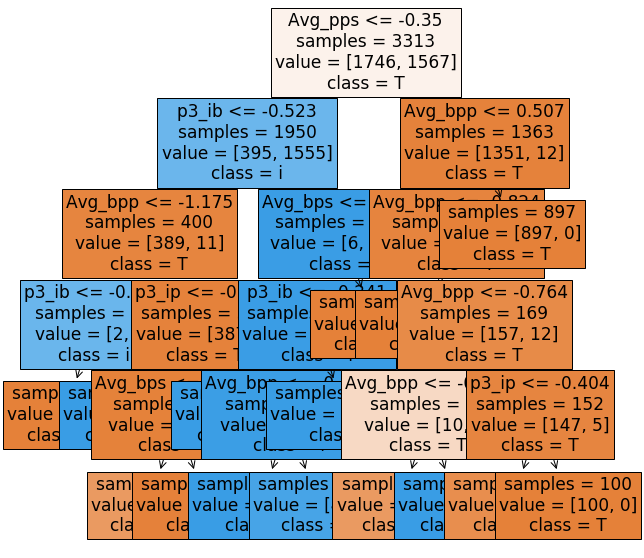

In [72]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [73]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [74]:
len(y_pred[y_pred == 0])

756

In [75]:
len(y_pred[y_pred == 1])

664

### Métricas y matriz de confusión

Matriz de confusión


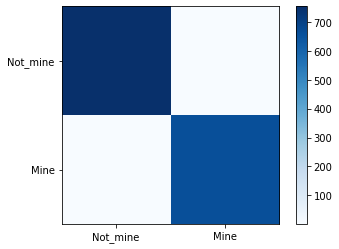

In [76]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [77]:
pd.DataFrame(churm)

,0,1
0,754,1
1,2,663


In [78]:
metricas(y_test, y_pred, churm)

Exactitud:  0.997887323943662
Kappa:  0.995757225663805
Metricas de los registros mineros
Precisión:  0.9984939759036144
Recall:  0.9969924812030075
Especificidad :  0.9986754966887417
F1-score      :  0.9977426636568848
Metricas de los registros no mineros
Precisión:  0.9973544973544973
Recall:  0.9986754966887417
Especificidad :  0.9969924812030075
F1-score      :  0.9980145598941098


In [79]:
mse, bias, var =  bias_variance_decomp(model, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='mse', num_rounds=200)

In [80]:
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.004
Bias: 0.002
Variance: 0.002


In [81]:
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None), X, y,cv=10,scoring='accuracy')

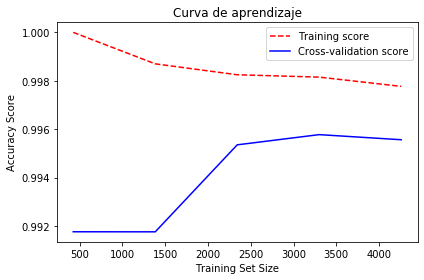

In [82]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="blue", label="Cross-validation score")

#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="gray")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="gray")

plt.title("Curva de aprendizaje")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Curva ROC

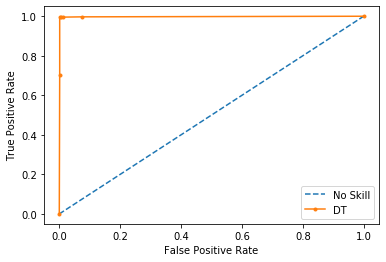

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.997


In [83]:
ROC(X_test,y_test,model)